In [1]:
# imports for array-handling and plotting
import tensorflow as tf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

# keep our keras backend tensorflow quiet
import os
os.environ['TF_CPP_MIN_LOG_LEVEL']='3'

# keras imports for the dataset and building our neural network
from keras.datasets import mnist
from keras.models import Sequential, load_model
from keras.layers.core import Dense, Dropout, Activation
from keras.utils import np_utils

/home/yuval/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [2]:
def build_model():
    # building a linear stack of layers with the sequential model
    model = Sequential()
    model.add(Dense(512, input_shape=(784,)))
    model.add(Activation('relu'))
    model.add(Dropout(0.2))

    model.add(Dense(512))
    model.add(Activation('relu'))
    model.add(Dropout(0.2))

    model.add(Dense(10))
    model.add(Activation('softmax'))

    print(model.summary())

    model.compile(loss='categorical_crossentropy', metrics=['accuracy'], optimizer='adam')
    return model

In [30]:
def plot_digits(X_train, y_train):
    fig = plt.figure()
    for i in range(9):
        plt.subplot(3,3,i+1)
        plt.tight_layout()
        plt.imshow(X_train[i], cmap='gray', interpolation='none')
        plt.title("Class {}".format(y_train[i]))
        plt.xticks([])
        plt.yticks([])
    fig


def plot_results(model):
    # plotting the metrics
    fig = plt.figure()
    plt.subplot(2,1,1)
    plt.plot(model.history['acc'])
    plt.plot(model.history['val_acc'])
    plt.title('model accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='lower right')

    plt.subplot(2,1,2)
    plt.plot(model.history['loss'])
    plt.plot(model.history['val_loss'])
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper right')

    plt.tight_layout()
    plt.show()
    fig

### load mnist train & test

In [4]:
(X_train, y_train), (X_test, y_test) = mnist.load_data()

# print the shape before we reshape and normalize
print("X_train shape", X_train.shape)
print("y_train shape", y_train.shape)
print("X_test shape", X_test.shape)
print("y_test shape", y_test.shape)

X_train shape (60000, 28, 28)
y_train shape (60000,)
X_test shape (10000, 28, 28)
y_test shape (10000,)


### building the input vector from the 28x28 pixels  

In [5]:
X_train = X_train.reshape(60000, 784)
X_test = X_test.reshape(10000, 784)
X_train = X_train.astype('float32')
X_test = X_test.astype('float32')

# normalizing the data to help with the training
X_train /= 255
X_test /= 255

# print the final input shape ready for training
print("Train matrix shape", X_train.shape)
print("Test matrix shape", X_test.shape)

Train matrix shape (60000, 784)
Test matrix shape (10000, 784)


### one-hot encoding using keras' numpy-related utilities

In [6]:
n_classes = 10
print("Shape before one-hot encoding: ", y_train.shape)
Y_train = np_utils.to_categorical(y_train, n_classes)
Y_test = np_utils.to_categorical(y_test, n_classes)
print("Shape after one-hot encoding: ", Y_train.shape)

Shape before one-hot encoding:  (60000,)
Shape after one-hot encoding:  (60000, 10)


### split train to labeled & unlabeld

In [7]:

labeled_size = .05
X_labeled, X_unlabeled, Y_labeled, Y_unlabeled = train_test_split(X_train, Y_train,
                                                                      train_size=labeled_size, stratify=y_train)
print("X_labeled shape", X_labeled.shape)
print("Y_labeled shape", Y_labeled.shape)
print("X_unlabeled shape", X_unlabeled.shape)
print("Y_unlabeled shape", Y_unlabeled.shape)

X_labeled shape (3000, 784)
Y_labeled shape (3000, 10)
X_unlabeled shape (57000, 784)
Y_unlabeled shape (57000, 10)


/home/yuval/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2026: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


### build model :

In [8]:

model = build_model()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 512)               401920    
_________________________________________________________________
activation_1 (Activation)    (None, 512)               0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 512)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 512)               262656    
_________________________________________________________________
activation_2 (Activation)    (None, 512)               0         
_________________________________________________________________
dropout_2 (Dropout)          (None, 512)               0         
_________________________________________________________________
dense_3 (Dense)              (None, 10)                5130      
__________

#### loop few iterations 

#### training the model on the labeled data and saving metrics in history

In [9]:
iteration = 0

history = model.fit(X_labeled, Y_labeled, batch_size=128, epochs=4, verbose=4, validation_data=(X_test, Y_test))

# check accuracy on test data
metrics = model.evaluate(X_test, y=Y_test, batch_size=128)

print('\n accuracy after {} iterations :'.format(iteration))

for i in range(len(model.metrics_names)):
    print(str(model.metrics_names[i]) + ": " + str(metrics[i]))

Train on 3000 samples, validate on 10000 samples
Epoch 1/4
Epoch 2/4
Epoch 3/4
Epoch 4/4
10000/10000 [==============================] - 0s 42us/step

 accuracy after 0 iterations :
loss: 0.27443797023296357
acc: 0.9136


### use the model to predict unlabeled data and create pseudo labeles

In [10]:
iteration = iteration+1

threshold = .999
predict = np.argmax(model.predict_proba(X_unlabeled),axis=1)
# select unlabeled samples with predictions probabilty above threshold :
X_pseudo_labeled = X_unlabeled[predict > threshold]
Y_pseudo_labeled = Y_unlabeled[predict > threshold]

print ('\n using threshold of {} - predicts {} pseudo labels from {} unlabeld samples'. \
    format(threshold, len(X_pseudo_labeled), len(X_unlabeled)))

# add pseudo labeled samples to labeled data :
X_mixed_labeled = np.concatenate((X_labeled, X_pseudo_labeled ), axis=0)
Y_mixed_labeled = np.concatenate((Y_labeled, Y_pseudo_labeled ), axis=0)


 using threshold of 0.999 - predicts 51337 pseudo labels from 57000 unlabeld samples


### check pseudo labels (compare to original train labels) : 

In [60]:
y_pseudo_labeled = np.argmax(Y_pseudo_labeled,axis=1)
y_unlabeled = np.argmax(Y_unlabeled,axis=1)
print (y_pseudo_labeled.shape ) 
print (y_unlabeled[0:y_pseudo_labeled.shape[0]].shape)
diff = y_pseudo_labeled - y_unlabeled[0:y_pseudo_labeled.shape[0]]
diff.sum()

(51337,)
(51337,)


24080

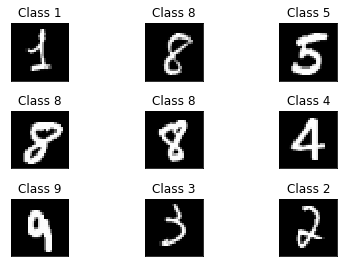

In [39]:

plot_digits(X_pseudo_labeled.reshape(X_pseudo_labeled.shape[0],28,28),y_pseudo_labeled)

   ### training the model on the pseudo labeled data and saving metrics in history

In [18]:
history = model.fit(X_mixed_labeled, Y_mixed_labeled, batch_size=128, epochs=4, verbose=4, validation_data=(X_test, Y_test))

# check accuracy on test data
metrics = model.evaluate(X_test, y=Y_test, batch_size=128)
print('\n accuracy after {} iterations :'.format(iteration))
for i in range(len(model.metrics_names)):
    print(str(model.metrics_names[i]) + ": " + str(metrics[i]))
    print('\n')

Train on 54337 samples, validate on 10000 samples
Epoch 1/4
Epoch 2/4
Epoch 3/4
Epoch 4/4
10000/10000 [==============================] - 1s 69us/step

 accuracy after 1 iterations :
loss: 0.05659585940737743


acc: 0.9836


